/tmp/ipython-input-2537586514.py:156: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cum_prof = np.trapz(prof, r_eval)
/tmp/ipython-input-2537586514.py:158: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  core_frac = np.trapz(prof[r_eval<=mid], r_eval[r_eval<=mid]) / (cum_prof + 1e-12)


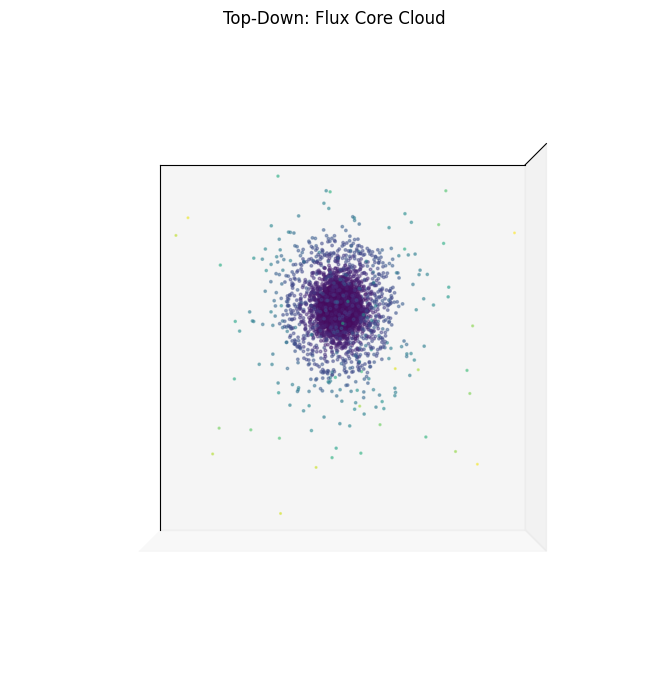

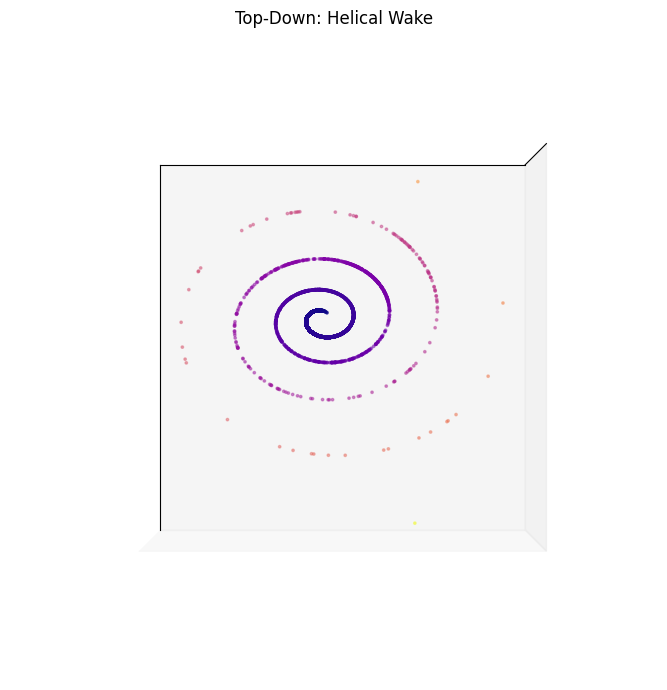

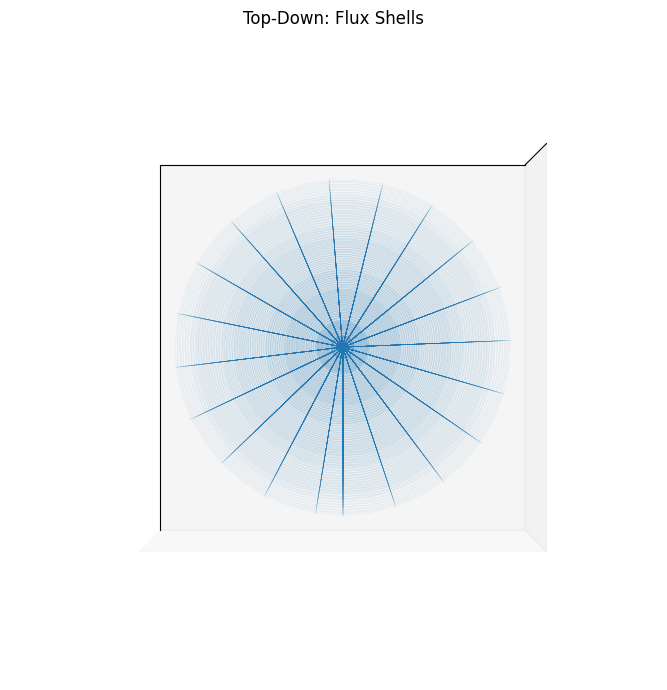

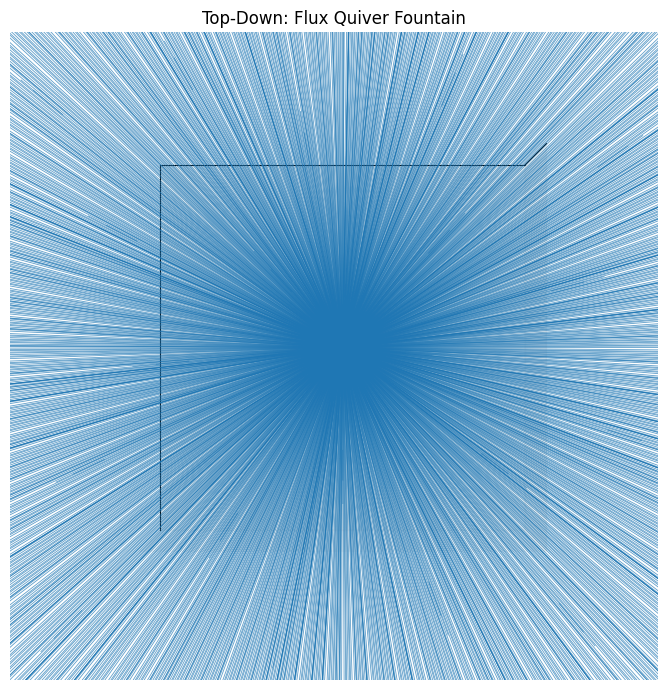

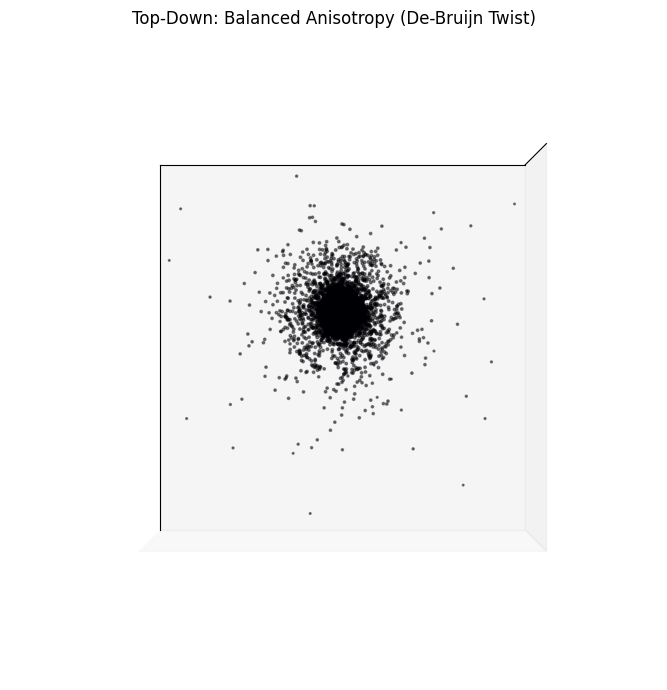

Saved top-down PNGs:
 /content/topdown_core_cloud.png
 /content/topdown_spiral_wake.png
 /content/topdown_flux_shells.png
 /content/topdown_flux_quiver.png
 /content/topdown_aniso_twist.png


interactive(children=(Dropdown(description='Scene:', layout=Layout(width='300px'), options=('Core cloud', 'Hel…

In [1]:
# === Prime–Golden–Sphere: Top-Down Renders + Interactive Viewer (Colab-safe) ===
# - Builds the same 3-D scenes from actual bin weights Σ p^(-φ).
# - Saves top-down PNGs (elev=90°) for each scene.
# - Provides an ipywidgets viewer with scene picker + camera sliders.

import math, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown
from IPython.display import display, clear_output

# -----------------------------
# Config (tweak safely)
# -----------------------------
phi = (1 + 5**0.5) / 2
PRIME_MAX_FOR_BINS = 100_000     # primes up to this value are binned
BINS_PER_DECADE = 12             # bin refinement per decade
TOTAL_POINTS_CORE = 35_000       # core cloud points
TOTAL_POINTS_SPIRAL = 25_000     # spiral plume points
SHELL_MESH_RES = (40, 20)        # sphere mesh density (lon, lat)
QUIVER_DIRS = 1600               # quiver arrows
ANISO_EPS = 0.18                 # de Bruijn twist strength
R_SEED = 7

np.random.seed(R_SEED)

# -----------------------------
# Small, fast prime sieve
# -----------------------------
def sieve_primes(n: int):
    if n < 2: return []
    s = bytearray(b'\x01')*(n+1)
    s[0:2] = b'\x00\x00'
    m = int(n**0.5)
    for p in range(2, m+1):
        if s[p]:
            s[p*p:n+1:p] = b'\x00'*((n-p*p)//p + 1)
    return np.nonzero(s)[0].tolist()

primes = sieve_primes(PRIME_MAX_FOR_BINS)

# -----------------------------
# Build log-like bins and weights w_i = Σ_{p in bin i} p^{-φ}
# -----------------------------
if PRIME_MAX_FOR_BINS < 10: PRIME_MAX_FOR_BINS = 10
decades = int(math.log10(PRIME_MAX_FOR_BINS))
edges = [2]
for d in range(1, decades+1):
    a, b = 10**d, 10**(d+1)
    step = (b - a) / BINS_PER_DECADE
    for k in range(BINS_PER_DECADE):
        edges.append(int(a + k*step))
edges.append(PRIME_MAX_FOR_BINS+1)
edges = sorted(list(set(edges)))

weights = []
for lo, hi in zip(edges[:-1], edges[1:]):
    ps = [p for p in primes if lo <= p < hi]
    if ps:
        w = float(np.sum(np.array(ps, dtype=float)**(-phi)))  # proportional to 4π Σ p^{-φ} per bin
    else:
        w = 0.0
    weights.append(w)
weights = np.array(weights, dtype=float)
if weights.sum() == 0: weights[0] = 1.0
W = weights / weights.sum()
nbins = len(W)
r_min, r_max = 0.08, 1.20
r_bins = np.linspace(r_min, r_max, nbins)

# -----------------------------------
# Helpers
# -----------------------------------
def sample_shell(n, r, jitter=0.03):
    u = np.random.rand(n); v = np.random.rand(n)
    az = 2*np.pi*u
    z = 2*v - 1
    xy = np.sqrt(np.maximum(0, 1 - z*z))
    x = xy*np.cos(az); y = xy*np.sin(az)
    rho = r * (1.0 + jitter * (np.random.rand(n) - 0.5))
    return rho*x, rho*y, rho*z

def fibonacci_sphere(n):
    k = np.arange(n)
    z = 1 - 2*(k + 0.5)/n
    t = np.pi * (1 + 5**0.5) * k
    r = np.sqrt(1 - z*z)
    return np.column_stack([r*np.cos(t), r*np.sin(t), z])

def de_bruijn_binary(n):
    k = 2; a = [0]*(k*n); seq = []
    def db(t, p):
        if t > n:
            if n % p == 0: seq.extend(a[1:p+1])
        else:
            a[t] = a[t-p]; db(t+1, p)
            for j in range(a[t-p]+1, k):
                a[t] = j; db(t+1, t)
    db(1,1); return seq

# -----------------------------------
# Build the five 3-D datasets once
# -----------------------------------
# 1) Core cloud (points + color by radius + size by radius)
inner_emphasis = np.linspace(1.15, 0.85, nbins)
alloc = W * inner_emphasis
alloc = (alloc / alloc.sum()) * TOTAL_POINTS_CORE
alloc = np.maximum(alloc.astype(int), 1)

XYZ_core = []
C_core = []
for i, n_i in enumerate(alloc):
    x,y,z = sample_shell(n_i, r_bins[i], jitter=0.06)
    XYZ_core.append(np.column_stack([x,y,z]))
    C_core.append(np.full((n_i,), r_bins[i]))
XYZ_core = np.vstack(XYZ_core)
C_core = np.concatenate(C_core)
sizes_core = 4.0 * (1.0 - 0.65*(C_core - r_min)/(r_max - r_min))

# 2) Helical wake (spiral plume)
N = TOTAL_POINTS_SPIRAL
cumW = np.cumsum(W)
t = np.linspace(0, 1, N)
bin_idx = np.searchsorted(cumW, t, side='right')
bin_idx = np.clip(bin_idx, 0, nbins-1)
r = r_bins[bin_idx] + np.random.normal(0, 0.01, size=N)
theta = 18.0 * np.log(1.0 + 4.0*r)
z_sp = 0.55*np.sin(1.8*theta) * (r / r_max)
x_sp = r*np.cos(theta); y_sp = r*np.sin(theta)
XYZ_spiral = np.column_stack([x_sp, y_sp, z_sp])
C_spiral = r
sizes_spiral = np.full(N, 3.0)

# 3) Flux shells (meshes per radius)
lon, lat = SHELL_MESH_RES
u = np.linspace(0, 2*np.pi, lon)
v = np.linspace(0, np.pi, lat)
uu, vv = np.meshgrid(u, v)
shells = []
for i, r in enumerate(r_bins):
    X = r*np.cos(uu)*np.sin(vv)
    Y = r*np.sin(uu)*np.sin(vv)
    Z = r*np.cos(vv)
    alpha = 0.12 + 0.45*(W[i]/W.max())
    shells.append((X, Y, Z, float(alpha)))

# 4) Quiver directions
dirs = fibonacci_sphere(QUIVER_DIRS)
# build a smooth radial density profile from bin weights
def radial_profile(r_eval):
    s = 0.0
    for rb, w in zip(r_bins, W):
        s += w * np.exp(-0.5*((r_eval - rb)/(0.18))**2)
    return s
r_eval = np.linspace(r_min, r_max, 400)
prof = radial_profile(r_eval)
cum_prof = np.trapz(prof, r_eval)
mid = (r_min + r_max)/2
core_frac = np.trapz(prof[r_eval<=mid], r_eval[r_eval<=mid]) / (cum_prof + 1e-12)
L0 = 0.35 + 0.8*core_frac
lengths = L0 * (0.9 + 0.2*np.random.rand(QUIVER_DIRS))
UV_quiver = dirs * lengths[:,None]

# 5) Balanced anisotropy (de Bruijn twist applied to core cloud)
B = de_bruijn_binary(16)  # length 65536
M = np.array([1 if b==1 else -1 for b in B], dtype=int)
idx = np.arange(XYZ_core.shape[0]) % len(M)
twist = ANISO_EPS * M[idx]
x,y,z = XYZ_core[:,0], XYZ_core[:,1], XYZ_core[:,2]
rho = np.sqrt(x*x + y*y + z*z) + 1e-12
az = np.arctan2(y, x) + twist
el = np.arccos(np.clip(z/rho, -1, 1))
x2 = rho * np.sin(el) * np.cos(az)
y2 = rho * np.sin(el) * np.sin(az)
z2 = rho * np.cos(el)
XYZ_twist = np.column_stack([x2,y2,z2])
C_twist = np.abs(twist)
sizes_twist = sizes_core.copy()

# -----------------------------------
#  A) Save top-down renders (elev=90°) for each scene
# -----------------------------------
def topdown_axes(title):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=90, azim=0)  # top-down
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_box_aspect([1,1,1])
    return fig, ax

# Core cloud top-down
fig, ax = topdown_axes("Top-Down: Flux Core Cloud")
ax.scatter(XYZ_core[:,0], XYZ_core[:,1], XYZ_core[:,2], c=C_core, s=sizes_core, alpha=0.45, cmap='viridis', depthshade=False)
plt.tight_layout(); plt.savefig("/content/topdown_core_cloud.png", dpi=180, bbox_inches="tight"); plt.show()

# Spiral wake top-down
fig, ax = topdown_axes("Top-Down: Helical Wake")
ax.scatter(XYZ_spiral[:,0], XYZ_spiral[:,1], XYZ_spiral[:,2], c=C_spiral, s=sizes_spiral, alpha=0.45, cmap='plasma', depthshade=False)
plt.tight_layout(); plt.savefig("/content/topdown_spiral_wake.png", dpi=180, bbox_inches="tight"); plt.show()

# Shells top-down
fig, ax = topdown_axes("Top-Down: Flux Shells")
for (X,Y,Z,alpha) in shells:
    ax.plot_wireframe(X, Y, Z, linewidth=0.35, alpha=alpha, rstride=2, cstride=2)
plt.tight_layout(); plt.savefig("/content/topdown_flux_shells.png", dpi=180, bbox_inches="tight"); plt.show()

# Quiver top-down
fig, ax = topdown_axes("Top-Down: Flux Quiver Fountain")
O = np.zeros_like(dirs)
ax.quiver(O[:,0],O[:,1],O[:,2], UV_quiver[:,0],UV_quiver[:,1],UV_quiver[:,2],
          length=1.0, normalize=False, linewidth=0.6, arrow_length_ratio=0.06, color='tab:blue', alpha=0.7)
plt.tight_layout(); plt.savefig("/content/topdown_flux_quiver.png", dpi=180, bbox_inches="tight"); plt.show()

# Aniso twist top-down
fig, ax = topdown_axes("Top-Down: Balanced Anisotropy (De-Bruijn Twist)")
ax.scatter(XYZ_twist[:,0], XYZ_twist[:,1], XYZ_twist[:,2], c=C_twist, s=sizes_twist, alpha=0.45, cmap='magma', depthshade=False)
plt.tight_layout(); plt.savefig("/content/topdown_aniso_twist.png", dpi=180, bbox_inches="tight"); plt.show()

print("Saved top-down PNGs:")
print(" /content/topdown_core_cloud.png")
print(" /content/topdown_spiral_wake.png")
print(" /content/topdown_flux_shells.png")
print(" /content/topdown_flux_quiver.png")
print(" /content/topdown_aniso_twist.png")

# -----------------------------------
#  B) Interactive viewer (scene picker + camera sliders)
# -----------------------------------
def render_scene(scene: str, elev: float, azim: float):
    clear_output(wait=True)
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]); ax.set_box_aspect([1,1,1])
    if scene == "Core cloud":
        ax.scatter(XYZ_core[:,0], XYZ_core[:,1], XYZ_core[:,2], c=C_core, s=sizes_core, alpha=0.45, cmap='viridis', depthshade=True)
        ax.set_title("Flux Core Cloud")
    elif scene == "Helical wake":
        ax.scatter(XYZ_spiral[:,0], XYZ_spiral[:,1], XYZ_spiral[:,2], c=C_spiral, s=sizes_spiral, alpha=0.45, cmap='plasma', depthshade=True)
        ax.set_title("Helical Wake")
    elif scene == "Flux shells":
        for (X,Y,Z,alpha) in shells:
            ax.plot_wireframe(X, Y, Z, linewidth=0.35, alpha=alpha, rstride=2, cstride=2)
        ax.set_title("Flux Shells")
    elif scene == "Flux quiver":
        O = np.zeros_like(dirs)
        ax.quiver(O[:,0],O[:,1],O[:,2], UV_quiver[:,0],UV_quiver[:,1],UV_quiver[:,2],
                  length=1.0, normalize=False, linewidth=0.6, arrow_length_ratio=0.06, color='tab:blue', alpha=0.7)
        ax.set_title("Flux Quiver Fountain")
    elif scene == "Aniso twist":
        ax.scatter(XYZ_twist[:,0], XYZ_twist[:,1], XYZ_twist[:,2], c=C_twist, s=sizes_twist, alpha=0.45, cmap='magma', depthshade=True)
        ax.set_title("Balanced Anisotropy (De-Bruijn Twist)")
    plt.show()
    # Keep the widgets visible:
    display(controls)

# Build widgets
scene_dd = Dropdown(options=["Core cloud", "Helical wake", "Flux shells", "Flux quiver", "Aniso twist"],
                    value="Core cloud", description="Scene:", layout={'width':'300px'})
elev_sl = FloatSlider(value=25.0, min=0.0, max=90.0, step=1.0, description='Elev:')
azim_sl = FloatSlider(value=35.0, min=0.0, max=360.0, step=1.0, description='Azim:')

def on_change(scene, elev, azim):
    render_scene(scene, elev, azim)

controls = interact(on_change, scene=scene_dd, elev=elev_sl, azim=azim_sl)
